##Import Libraries

In [19]:
import numpy  as np
import matplotlib.pyplot as plt


In [20]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout
from keras.layers import LSTM, CuDNNLSTM, MaxPooling1D, Conv1D, Flatten
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt
from pandas import Series
from numpy.random import randn
import os
import random
import numpy as np
import time
import tensorflow as tf

In [21]:
print(tf. __version__)

2.6.0


## Generate Sine Wave data

In [22]:
time = np.arange(0,768,0.1);

In [23]:
time

array([0.000e+00, 1.000e-01, 2.000e-01, ..., 7.677e+02, 7.678e+02,
       7.679e+02])

In [24]:
amplitude = np.sin(time)

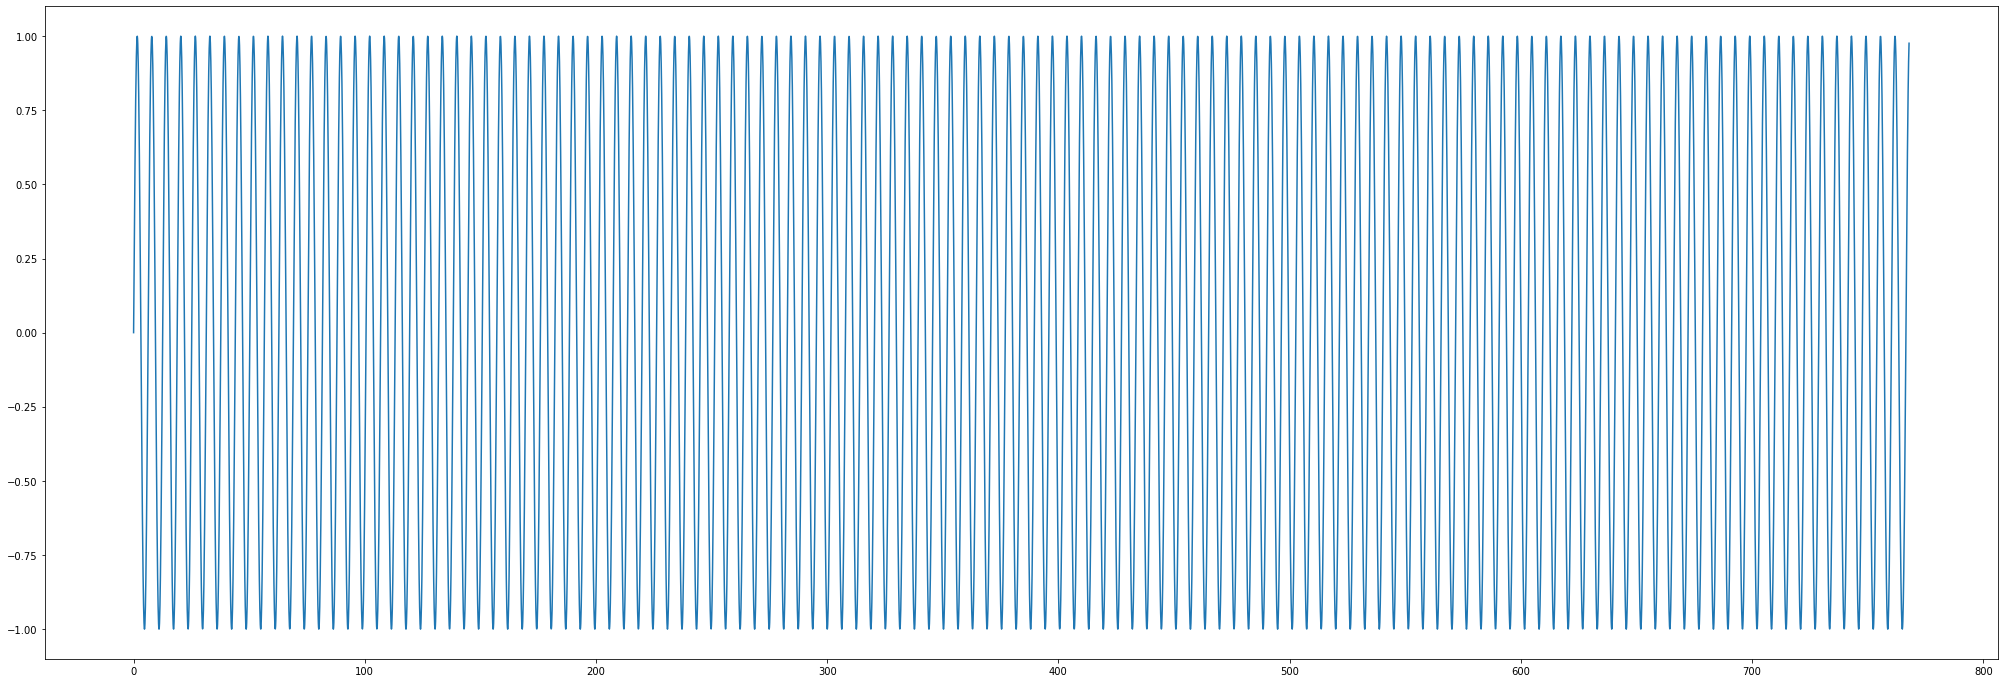

In [25]:
#plot the sine wave dataseries
plt.plot(time,amplitude)
plt.rcParams["figure.figsize"] = (35,12)

In [26]:
#using the MachineLearningMastery formula for splitting up the dataset to predictors and target
#reference: https://towardsdatascience.com/single-and-multi-step-temperature-time-series-forecasting-for-vilnius-using-lstm-deep-learning-b9719a0009de
def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series array for the training of 
    deep learning models 
    """
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    
    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an LSTM input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

In [27]:
#Here we need to set up a number of parameters for how we process the data before we feed it in the model

# Number of lags (historical data points) to use for models
lag = 256
# Number of steps in future to forecast ahead 
n_ahead = 128
# ratio of training data set (70%, 10% for validation and 20% for testing)
train_share = 0.7
#ration of validation data set (10%)
val_share = 0.8
# training epochs
epochs = 10
# Batch size , which is the number of samples of lags
batch_size = 1
# Learning rate
lr = 0.001

In [28]:
data = amplitude.reshape(-1,1)

In [29]:
data.shape

(7680, 1)

In [30]:
#Scaling data between 0 and 1
scaler = MinMaxScaler()
scaler.fit(data)
ts_scaled = scaler.transform(data)

In [31]:
# Creating the X and Y for training
X, Y = create_X_Y(ts_scaled, lag=lag, n_ahead=n_ahead)

In [32]:
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * train_share)], Y[0:int(X.shape[0] * train_share)]
Xtest, Ytest = X[int(X.shape[0] * val_share):], Y[int(X.shape[0] * val_share):]
Xval, Yval = X[int(X.shape[0] * train_share):int(X.shape[0] * val_share)], Y[int(X.shape[0] * train_share):int(X.shape[0] * val_share)]

In [33]:
Xtrain.shape

(5107, 256, 1)

In [34]:
Xtest.shape

(1460, 256, 1)

In [35]:
Xval.shape

(729, 256, 1)

## Configure Neural Network Model

In [36]:
#Neural Network Model configuration
model = Sequential()

#model.add(LSTM(32, activation='relu', input_shape=(Xtrain.shape[1], Xtrain.shape[2]), return_sequences=True))
model.add(CuDNNLSTM(32, input_shape=(Xtrain.shape[1], Xtrain.shape[2]), return_sequences=True))
#model.add(LSTM(16, activation='relu', return_sequences=False))
model.add(CuDNNLSTM(16, return_sequences=False))
model.add(Dense(128))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta=0.001)
model.summary()

model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics='mae')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_2 (CuDNNLSTM)     (None, 256, 32)           4480      
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 16)                3200      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2176      
Total params: 9,856
Trainable params: 9,856
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
160/160 [==============================] - 4s 20ms/step - loss: 0.3403 - mae: 0.3403 - val_loss: 0.2430 - val_mae: 0.2430
Epoch 2/10
160/160 [==============================] - 3s 18ms/step - loss: 0.0897 - mae: 0.0897 - val_loss: 0.0288 - val_mae: 0.0288
Epoch 3/10
160/160 [==============================] - 3s 18ms/step - loss: 0.0147 - mae: 0.0147 - val_loss: 0.0090 - val_mae: 0.0090
Epoch 4/10
160/160 [==============================] - 3s 18ms/step - loss: 0.0100 - mae: 0.0100 - val_loss: 0.0069 - val_mae: 0.0069
Epoch 5/10
160/160 [==============================] - 3s 18ms/step - loss: 0.0084 - mae: 0.0084 - val_loss: 0.0084 - val_mae: 0.0084
Epoch 6/10
160/160 [==============================] - 3s 18ms/step - loss: 0.0083 - mae: 0.0083 - val_loss: 0.0056 - val_mae: 0.0056
Epoch 7/10
160/160 [==============================] - 3s 18ms/step - loss: 0.0098 - mae: 0.0098 - val_loss: 0.0070 - val_mae: 0.0070
Epoch 8/10
160/160 [==============================] - 3s 18ms/step - 

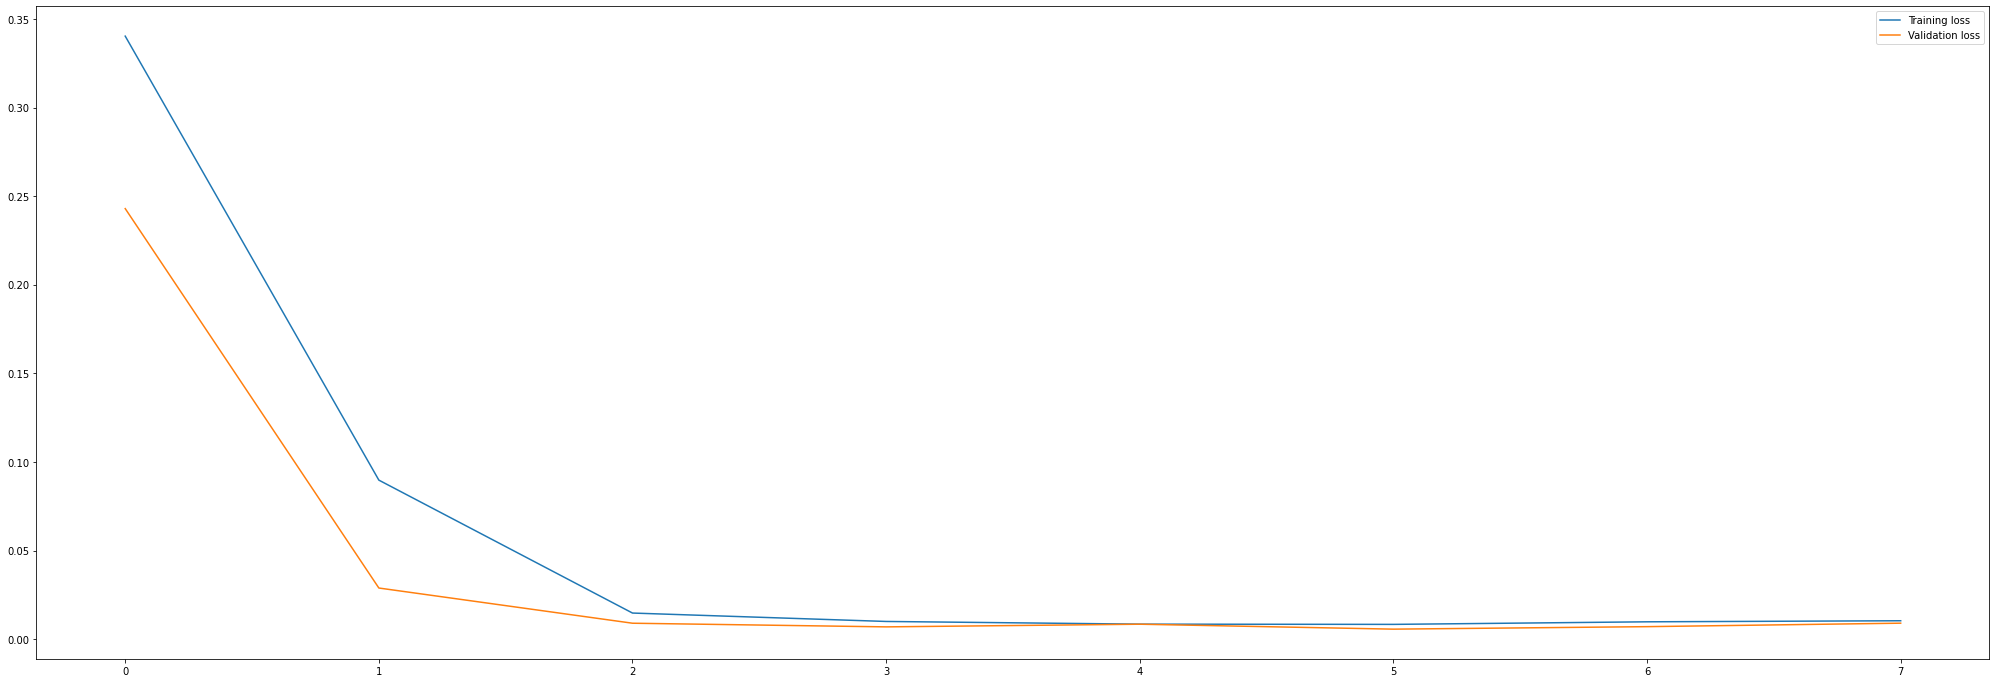

In [37]:
#Train model on train data
history = model.fit(Xtrain, Ytrain,epochs=epochs, validation_data=(Xval, Yval), shuffle=False, callbacks=[early_stopping])
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()

In [38]:
#yhat = [x[0] for x in model.predict(Xtest)]
#y = [y[0] for y in Ytest]

In [39]:
yhat = model.predict(Xtest)
yhat.shape

(1460, 128)

In [40]:
pred_n_ahead = pd.DataFrame(yhat[0])
actual_n_ahead = pd.DataFrame(Ytest[0])

#inverse scale tranform the seires back to power kWs
pred_n_ahead = pd.DataFrame(scaler.inverse_transform(pred_n_ahead))
actual_n_ahead = pd.DataFrame(scaler.inverse_transform(actual_n_ahead))

In [41]:
Ytest.shape

(1460, 128)

<function matplotlib.pyplot.show>

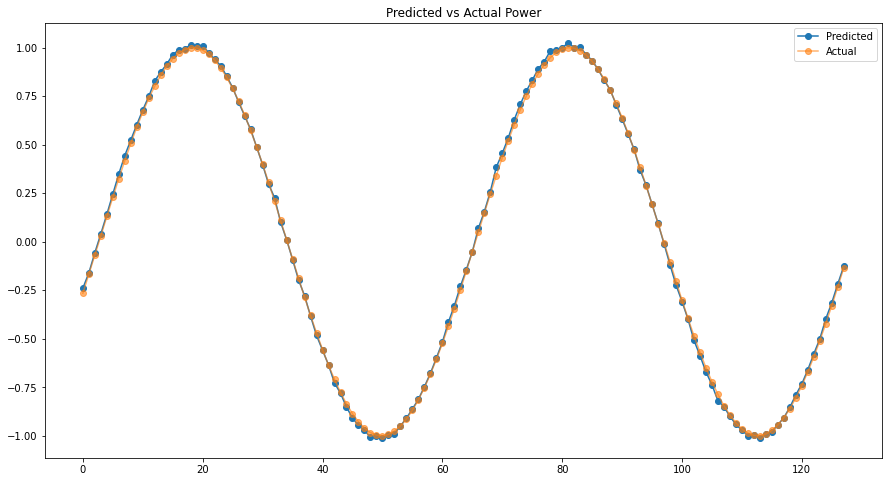

In [42]:
#plot n_steps ahead for predicted and actual data
plt.figure(figsize=(15, 8))
plt.plot(pred_n_ahead, color='C0', marker='o', label='Predicted')
plt.plot(actual_n_ahead, color='C1', marker='o', label='Actual', alpha=0.6)
plt.title('Predicted vs Actual Power')
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.legend()
plt.show

In [43]:
#evaluation metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    return({'mape':mape, 'me':me, 'mae': mae,  'rmse':rmse, 
            'corr':corr})

forecast_accuracy(yhat,Ytest)

{'corr': 0.9952103163201043,
 'mae': 0.008916245111416001,
 'mape': 3.877939176336924,
 'me': 0.0018967748051227711,
 'rmse': 0.011831275493604554}